Пример программы:
```csharp
using System;
using System.Windows.Forms;
using System.Collections.Specialized;

namespace WindowsFormsApplication1
{
    public partial class Form1 : Form
    {
        Properties.Settings set = Properties.Settings.Default;

        public Form1()
        {
            InitializeComponent();
        }
```

```csharp
        private void Form1_Load(object sender, EventArgs e)
        {
            // Проверить: это первый запуск, то есть список параметра пустой?
            if (set.Strings == null || set.Strings.Count == 0)
            {
                // Добавить элементы из списка ComboBox в коллекцию параметра Strings, чтобы сработала привязка.
                set.Strings = new StringCollection();
                string[] arr = new string[comboBox1.Items.Count];
                comboBox1.Items.CopyTo(arr, 0);
                set.Strings.AddRange(arr);
                set.comboText = comboBox1.Text;
            }

            bindingSource1.DataSource = set.Strings;
            comboBox1.DataSource = bindingSource1;
            comboBox1.Text = set.comboText;
        }
```

```csharp
        private void Добавить_Click(object sender, EventArgs e)
        {
            set.Strings.Add(textBox2.Text);
            bindingSource1.ResetBindings(false);
        }

        private void Выход_Click(object sender, EventArgs e)
        {
            set.comboText = comboBox1.Text;
            set.Save();
            Close();
        }
    }
}
```

Таким образом, технология параметров является удобной технологией: создается класс, который запоминает параметры в XML-файле, а при первом обращении к параметру читает этот файл, поэтому параметры можно использовать для различных целей, причем не связанных с элементами управления. Некоторые задачи выходят за рамки ограничений и для их решения необходимо знание архитектуры параметров. Для таких задач приходится вручную писать вспомогательный код. Далее рассмотрим создание класса параметров вручную, то есть без использования Visual Studio.

Страница 301

-------

# СОЗДАНИЕ ПАРАМЕТРОВ ПРОГРАММЫ ВРУЧНУЮ
В предыдущем разделе мы выяснили, что среда Visual Studio предоставляет удобную технологию по созданию параметров приложения и параметров пользователя. Она выполняет следующие задачи:
* автоматически создает типизированный класс параметров, являющийся оболочкой системного класса `ApplicationSettingsBase`;
* включает во вторую часть класса `Form1` проекта (файл `Form1.Designer.cs`) простую привязку выбранных свойств элементов управления к ассоциированным параметрам пользователя;
* для параметров приложения в этом же файле устанавливает настройку соответствующих свойств, присваивая им значения ассоциированных параметров;
* организовывает рабочее пространство и выполняет многие другие задачи;
* создает XML-файл со значениями параметров по умолчанию.


Для решения нетипичных задач среда предоставляет файл `Settings.cs`, являющийся частью класса-оболочки, доступной разработчику. Выше мы уже использовали этот файл. Однако, если требуется более тонкое управление параметрами, можно определить собственный класс-оболочку параметров приложения. Для этого необходимо создать производный класс от `ApplicationSettingsBase`, добавить свойство, соответствующее каждому параметру, и применить специальные атрибуты к этим свойствам. Можно также использовать класс для программной привязки свойств формы и элементов управления к параметрам. Важный момент: при управлении параметрами вручную XML-файл `app.exe.config` создаваться не будет — все умолчаемые значения будут выбираться из атрибутов свойств параметров.

Страница 302

----------------------------

# Простое приложение с параметром
Приведем пример разработки простейшего приложения с ручным управлением параметрами.
1. Создайте форму с кнопкой для изменения фона формы. Добавьте диалоговое окно `ColorDialog` (см. рис. 12.12).

    œ Form _OX
    Кнопка: отобразить окно цветов

Рис. 12.12. Форма приложения.

2. Добавьте в проект новый класс и присвойте ему имя `MySettings`. В определении класса установите наследование от базового класса `ApplicationSettingsBase`:
```csharp
sealed class MySettings : ApplicationSettingsBase
```
3. Определите в классе `MySettings` свойство для каждого требуемого параметра приложения и примените к нему атрибут `ApplicationScopedSettingAttribute` или `UserScopedSettingAttribute` в зависимости от области параметра. Мы создадим свойство `FormBackColor` для параметра пользователя со значением по умолчанию `AliceBlue`. На данном этапе код должен выглядеть следующим образом:

```csharp
using System;
using System.Configuration;
using System.Drawing;

sealed class MySettings : ApplicationSettingsBase
{
    [UserScopedSettingAttribute]
    [DefaultSettingValueAttribute("AliceBlue")]
    public Color FormBackColor
    {
        get { return (Color)this["FormBackColor"]; }
        set { this["FormBackColor"] = value; }
    }
}
```
Страница 303

-------------

4. Создайте экземпляр `mySet` данного класса-оболочки. После создания экземпляра можно выполнить привязку к свойству — в данном случае к свойству `BackColor` формы. Сделаем это в обработчике события `Load` формы:
```csharp
MySettings mySet = new MySettings();

private void Form1_Load(object sender, EventArgs e)
{
    this.DataBindings.Add("BackColor", mySet, "FormBackColor", true, DataSourceUpdateMode.OnPropertyChanged);
}
```

5. Создайте обработчик события `Click` для кнопки «Отобразить окно цветов». В обработчике вызовите диалоговое окно `colorDialog1` и измените цвет формы.
```csharp
private void btnBackColor_Click(object sender, EventArgs e)
{
    if (DialogResult.OK == colorDialog1.ShowDialog())
    {
        this.BackColor = colorDialog1.Color;
    }
}
```
Страница 304

------------

6. Так как предоставляется возможность изменения параметров во время выполнения, необходимо сохранять текущие параметры пользователя в XML-файле `user.config` при закрытии формы, иначе эти изменения будут потеряны. Создайте в окне свойств обработчик события `FormClosing` для формы:
```csharp
private void Form1_FormClosing(object sender, FormClosingEventArgs e)
{
    mySet.Save();
}
```

На этом разработка учебного проекта закончена. При первом запуске приложения фоновый цвет окна будет выбираться из атрибута `DefaultSettingValueAttribute` и будет соответствовать цвету `Color.AliceBlue`. Если изменить цвет формы и закрыть форму, то при следующем запуске форма будет закрашена сохраненным цветом. Обратите внимание на формат конструктора `Binding`, который используется для привязки свойства формы `BackColor` к параметру. Важно, чтобы был задан последний параметр со значением `DataSourceUpdateMode.OnPropertyChanged`, иначе свойство формы `BackColor` не будет сохраняться в параметре.

# Приложение с обработкой событий SettingChanging и SettingsSaving
Приведем более сложный пример приложения с обработкой событий `SettingChanging` и `SettingsSaving`. На рис. 12.13 показано окно этого приложения со следующими элементами управления:
* кнопка с именем `btnBackColor` (используется для отображения цвета, выбираемого из диалогового окна `ColorDialog`);
* кнопка с именем `btnReload` (используется для перезагрузки параметров с помощью метода `Reload`);
* кнопка с именем `btnReset` (используется для восстановления умолчаемых значений параметров с помощью метода `Reset`);
* элемент управления `StatusStrip` c `ToolStripStatusLabel` с именем `tbStatus` (используется для отображения текущего состояния программы).

Страница 305

--------

    Œ Fomm1 _OX
    Кнопка: изменить цвет формы
    Кнопка: binReload
    Кнопка: btnReset
    Какой-то текст.

Рис. 12.13. Форма приложения

В приложение также было добавлено диалоговое окно `ColorDialog` с именем `colorDialog1`. В приведенной ниже программе (файл `Form1.cs`) показано, как использовать параметры приложения, чтобы сохранить следующие свойства формы: расположение, размер, цвет фона и текст заголовка окна. Перечисленные свойства формы в классе-оболочке `FormSettings` ассоциированы соответственно с параметрами `FormLocation`, `FormSize`, `FormBackColor` и `FormText`. Все параметры, за исключением `FormText` и `Size`, применяют значение по умолчанию, используя атрибут `DefaultSettingValueAttribute`. Заметьте, после каждого выполнения приложения к тексту названия формы присоединяется дополнительный периодический символ «точка» (см. рис. 12.14).

Страница 306

---------

    Œ Fomm1 _OX
    Кнопка: изменить цвет формы
    Кнопка: binReload
    Кнопка: btnReset
    formlocation: (X= 380, V= 151)

Рис. 12.14. Окно приложения после повторного запуска

Приведем текст программы (фаил rorm1.cs).

    using System;
    using System.ComponentModel;
    using System. Configuration;
    using System.Drawing;
    using System. Windows.Forms;

Страница 307

--------

    namespace WFApp1
    {
        partial class Form1 : Form
        {
            private FormSettings mySet = new FormSetting»();
            public Form1()
            {
                InitializeComponento;
            )
            private void Form1_Load(object sender, EventArgs e)
            {
                this.FormClosing + = new FormClosingEventHandler(Form1_FormClosing);
                //Связать обработчики событий свойств параметров.
                mySet.SettingChanging +=
                    new SettingChangingEventHandler(mySet_SettingChanging)
                ;
                mySet.SettingsSaving +=
                    new SettingsSavingEventHandler(mySet_SettingsSaving)
                ;

                //Привязать свойства элементов управления к параметрам.
                Binding bndBackColor = new Binding(
                    "BackColor"
                    , mySet
                    , "FormBackColor"
                    , true
                    , DataSourceUpdateMode.OnPropertyChanged
                );
                this.DataBindings.Add(bndBackColor):
                Binding bndLocation = new Binding(
                    "Location"
                    , mySet
                    , "FormLocation"
                    , true
                    , DataSourceUpdateMode.OnPropertyChanged
                );
                this.DataBindings.Add(bndLocation);
                // Присвойте значение свойству Size, так как привязка
    
Страница 308

---------

                //
                // DataBinding к Size работает не корректно.
                this.Size = mySet.FormSize;
                String savedText = mySet.FormText;
                //Так как нет значения по умолчанию для FormText.
                if (savedText |= null)
                {
                    this.Text = savedText;
                }

                private void Form1_FormClosing(object sender, FormClosingEventArgs e)
                {
                    // Ручная синхронизация.
                    mySet.FormText = this. Text + ';
                    mySet.FormSize = this.Size;
                    // Сохранение параметров в файле.
                    mySet.Save();
                }
                private void btnBackColor_Click(object sender, EventArgs e)
                {
                    if (DialogResult.OK == colorDialog1.ShowDialog())
                        this.BackColor = colorDialog1.Color;
                }

                private void btnReset Click(obiect sender. EventArgs e)
                {
                    mySet.Reset();
                    this.BackColor = SystemColors.Control;
                }
                private void binReload_Click(object sender, EventArgs e)
                {
                    mySet.Reload();
                )
                void mySet_SettingChanging(object sender, SettingChangingEventArgs e)
                {
                    tbStatus.Text = e.SettingName +": " + e.NewValue;
                }

Страница 309

--------

                void mySet_SettingsSaving(object sender, CancelEventArgs e)
                {
                    DialogResult dr = MessageBox.Show(
                        "Сохранить текущие значения параметров приложения?"
                        , "Save Settings"
                        , MessageBoxButtons.YesNo
                    );
                    if (dr == DialogResult.No)
                        e.Cancel = true;
                }
            }


            // Класс параметров
            sealed class FormSettings: ApplicationSettingsBase
            {
                [UserScopedSettingAttribute()]
                public String FormText
                {
                    get 
                    {
                        return (String)this["FormText"];
                    }
                    set
                    {
                        this["FormText"] = value;
                    }
            }

            [UserScopedSettingAttribute()]
            [DefaultSettingValueAttribute(*0, 0*))
            public Point FormLocation
            {
                get
                {
                    return (Point)(this["FormLocation"]);
                }
                set
                {
                    this["FormLocation*] = value;
                }
            }
            [UserScopedSettingAttribute())
            [DefaultSetting ValueAttribute("370, 260")]
            public Size Formsize
            {
                get
                { 
                    return (Size)this"FormSize"];
                }
                set
                {
                    this["FormSize"] = value;
                }
            }

            [UserScopedSettingAttribute()]
            [DefaultSettingValue Attribute("Light")]
            public Color FormBackColor
            {
                get
                {
                    return (Color) this["FormBackColor"];
                }
                set
                {
                    this[«FormBackColor»] = value;
                }
            }
        }
    }

Обратите внимание на создание объекта класса-оболочки для параметров формы:
```csharp
private FormSettings mySet = new FormSettings();
```
Доступ к параметрам программы осуществляется через ссылку `mySet`. Запустим приложение, изменив цвет фона формы на бирюзовый и размеры/положение окна. При повторном закрытии и запуске программы сохраняются предыдущие значения свойств формы (см. рисунок 12.14).

Страница 310

--------

# ПРОВЕРКА ПАРАМЕТРОВ ПЕРЕД ИХ СОХРАНЕНИЕМ
"Поскольку параметры программы строго типизированы, существует некоторая уверенность, что пользователи не могут назначить тому или иному параметру данные неправильного типа. Однако пользователь может присвоить параметру значение, которое находится вне допустимых границ, например, задать дату рождения в будущем." Проверить значение можно традиционными способами, однако также возможно использование метода, предложенного **технологией параметров**. Родительский класс всех классов параметров `ApplicationSettingsBase` предоставляет четыре события для поддержки проверки допустимости данных. Используемое событие зависит от времени проверки параметров:

- **SettingsLoaded**:
  Возникает после начальной загрузки группы свойств параметров и используется для проверки начальных значений всех свойств перед их использованием в приложении.

- **SettingChanging**:
  Происходит до изменения значения отдельного свойства. Используется для проверки конкретного свойства перед его изменением, позволяя немедленно уведомить пользователя о неверных данных.

- **PropertyChanged**:
  Возникает после изменения значения свойства и редко применяется для проверки значений, за исключением случаев необходимости асинхронной продолжительной проверки.

- **SettingsSaving**:
  Срабатывает перед сохранением группы свойств параметров на диск. Используется для проверки всех значений в группе перед их сохранением.

Страница 311

------

Как правило, в программе не требуется использовать все эти события одновременно для проверки значений — часто удается выполнить все требования проверки, обрабатывая только событие `SettingChanging`. Обработка этого события помещает весь код проверки в одном месте, а не разбрасывает его по всему проекту. Обычно при обнаружении недопустимого значения обработчик событий выполняет одно из следующих действий:
* Автоматически предоставляет значение, которое заведомо правильно, например значение по умолчанию.
* Повторно запрашивает сведения у пользователя программы.
* Для событий, возникающих до выполнения действий над параметром, таких как `SettingChanging` и `SettingsSaving`, использует аргумент `CancelEventArgs e` для отмены операции изменения свойства параметра.

Страница 312

---------

Следующие процедуры показывают, как проверить допустимость даты рождения с помощью события `SettingChanging` или `SettingsSaving`. Процедуры были написаны в предположении, что параметры программы уже созданы; в этом примере будет выполнена проверка границ для параметра с именем `DateOfBirth`. Получите ссылку на объект параметров приложения (экземпляр класса-оболочки), выполнив один из следующих пунктов списка:
* Если параметры были созданы в визуальном режиме с помощью средств Visual Studio, можно получить объект параметров по умолчанию с помощью следующего свойства: `Properties.Settings.Default`.
* Если параметры были созданы вручную путем непосредственного наследования от класса `ApplicationSettingsBase`, экземпляр класса создается вручную, например так: `MyCustomSettings settings = new MyCustomSettings();`

Теперь к свойствам параметров можно обращаться, используя ссылку `settings`. Следующие процедуры были написаны в предположении, что объект параметров программы был получен вручную и имеет имя `settings`.

Страница 313

------

Чтобы проверить параметр программы перед его изменением, выполните следующие действия.

1. В обработчике события `Load` формы подпишитесь на событие `SettingChanging` для обработчика `MyCustomSettings_SettingChanging`:
```csharp
public void Form1_Load(Object sender, EventArgs e)
{
    settings.SettingChanging += MyCustomSettings_SettingChanging;
}
```

2. Определите обработчик событий `MyCustomSettings_SettingChanging` и напишите внутри него код для выполнения проверки границ даты рождения:

```csharp
private void MyCustomSettings_SettingChanging(Object sender, SettingChangingEventArgs e)
{
    if (e.SettingName == "DateOfBirth") // Если это DateOfBirth
    {
        DateTime newDate = (DateTime)e.NewValue;
        if (newDate.Date > DateTime.Now.Date)
        {
            e.Cancel = true; // Отменить изменение параметра.
            MessageBox.Show("Введите правильную дату рождения.");
        }
    }
}
```

Чтобы проверить группу параметров перед их сохранением, выполните следующие действия:
1. В обработчике события `Load` формы подпишитесь на событие `SettingsSaving` для обработчика `MyCustomSettings_SettingsSaving`:
```csharp
public void Form1_Load(Object sender, EventArgs e)
{
    settings.SettingsSaving += MyCustomSettings_SettingsSaving;
}
```
2. Определите обработчик событий `MyCustomSettings_SettingsSaving` и напишите внутри него код для разрешения/запрещения изменения даты рождения:
```csharp
private void MyCustomSettings_SettingsSaving(Object sender, SettingsSavingEventArgs e)
{
    // Здесь доступны ВСЕ параметры программы.
    if (settings.DateOfBirth > DateTime.Now.Date)
    {
        e.Cancel = true; // Отменить сохранение параметров.
    }
}
```
Разработайте программу полностью, создав форму с календарем. Реализуйте один из способов проверки параметра и сохраните параметр при завершении программы.

Страница 314

-----------

# Группы параметров — дополнительные сведения.

Если приложение имеет несколько классов-оболочек параметров, каждый класс определяет группу параметров (settings group). Каждая группа имеет следующие характеристики:
* Группа может содержать любое количество типов или параметров свойств.
* Если имя группы точно не установлено во время оформления класса-оболочки при помощи атрибута `SettingsGroupNameAttribute`, тогда имя создается автоматически.

# Пользовательские поставщики параметров.

Класс параметров по умолчанию использует поставщика параметров `LocalFileSettingsProvider`. Однако разработчик может реализовать сохранение параметров в месте, отличном от принятого, например в базе данных. Для этого разработчик должен разработать своего поставщика параметров. При желании использовать альтернативного поставщика параметров класс-оболочка или свойство должны иметь атрибут `SettingsProviderAttribute`. Подробно разработка пользовательского поставщика описана в документации Microsoft.

Страница 315

--------

# Сериализация параметров.

Если поставщику `LocalFileSettingsProvider` требуется сохранить параметры на диск, он выполняет перечисленные ниже действия:
1. Использует отражение для проверки всех свойств, определенных для производного от `ApplicationSettingsBase` класса, выявляя свойства, примененные с атрибутами `ApplicationScopedSettingAttribute` и `UserScopedSettingAttribute`.
2. Сохраняет каждое свойство на диск. Сначала пытается вызвать метод `ConvertToString` или `ConvertFromString` связанного с типом класса `TypeConverter`. Если это не удается, использует XML-сериализацию.
3. Распределяет параметры по файлам на основании атрибута параметра.

Если реализован собственный класс параметров, атрибут `SettingsSerializeAsAttribute` можно использовать для пометки свойства как предназначенного для двоичной или пользовательской сериализации с помощью перечисления `SettingsSerializeAs`. Обязательный XML-элемент `serializedAs` задает формат, используемый для сериализации в текстовое представление. Допустимые значения:
* `string` — значение сериализуется в виде строки с помощью класса `TypeConverter`.
* `xml` — значение сериализуется с использованием сериализации XML.
* `binary` — значение сериализуется с использованием двоичной сериализации.
* `custom` — поставщик параметров имеет встроенные сведения об этом параметре для проведения сериализации и десериализации.

При использовании двоичной и пользовательской сериализации необходимо определить собственный класс параметров и использовать класс `SettingsSerializeAsAttribute` для задания двоичной или пользовательской сериализации.

Страница 316

--------

# 12.2. Сохранение в файле с помощью StreamWriter
Ниже рассматривается простой способ сохранения и восстановления свойств формы и элементов управления в текстовом файле с помощью классов `StreamWriter` и `StreamReader` соответственно. Отличие этого способа от рассмотренной выше технологии, основанной на параметрах, заключается не только в отказе от XML-сериализации, но и в том, что для сохранения свойств параметры не используются.

# СОХРАНЕНИЕ ДАННЫХ ИНТЕРФЕЙСА В ТЕКСТОВОМ ФАЙЛЕ

Сохранение свойств формы и элементов управления связано с рядом трудностей. Во-первых, нельзя сохранить целиком элементы управления, используя XML-сериализацию, так как элементы управления содержат члены, являющиеся интерфейсами. Правда, можно создать свой класс со свойствами для запоминания сохраняемых значений, а затем сериализовать экземпляр этого класса. Но в этом случае мы пойдем по пути повторения рассмотренной выше технологии фирмы Microsoft, основанной на параметрах. Не думаю, что в нашем случае получится более удобная и проработанная технология. Поэтому мы рассмотрим более простой способ сохранения свойств формы и элементов управления в файле с помощью класса потокового вывода. В отличие от технологии параметров, разработчик сам определяет, когда необходимо прочитать файл. Поскольку свойства формы и элементов управления желательно иметь в формате, удобном для дальнейшей работы (например, для просмотра и изменения в Блокноте), будем преобразовывать сохраняемые значения в строки и записывать их в текстовый файл с помощью класса `StreamWriter`. Еще одно замечание. Если списочный элемент управления привязан к источнику данных, то будем сохранять источник, так как он не сохраняется самостоятельно, как, например, таблицы в базе данных. Для примера рассмотрим сохранение элементов `ComboBox`, `CheckBox` и `TextBox`. Пусть `ComboBox` содержит коллекцию строк типа `string`. Коллекции выделенных строк и их индексов сохранять не будем. Сохранять элементы управления будем при закрытии программы в обработчике события `Form1_Closed`. Для нашего примера создадим форму, показанную на рис. 12.15. Кнопки «+» и «-» будут использоваться для добавления новой строки в список и соответственно для удаления текущей из списка.

Страница 317

-------

    œ Form1 _OX
    [Москва]
    Автомобили:
    [Мерседе▾]
        <Audi
        <Mazda
        <Ford
        <Volkswagen
        <BMV
        <Renault
    [X]автовладелец
    Кнопка:+
    Кнопка:-
Рис. 12.15. Окно программы

Страница 318

--------

Введем в обработчик `Form1_FormClosed` следующий код для сохранения значений в файле:
```csharp
using System.IO;

private void Form1_FormClosed(object sender, FormClosedEventArgs e)
{
    // Сохранить параметры программы
    try
    {
        StreamWriter sout = new StreamWriter("Params.txt");
        // Запомнить флажок.
        sout.WriteLine(checkBox1.Checked);
        // Запомнить список.
        sout.WriteLine("**Начало списка**");
        sout.WriteLine(comboBox1.Text); // Текущая строка.
        foreach (string v in comboBox1.Items)
            sout.WriteLine(v);
        sout.WriteLine("**Конец списка**");
        // Запомнить текстовое поле.
        sout.WriteLine(textBox1.Text);
        sout.Close(); // Закрыть поток.
    }
    catch (Exception exc)
    {
        MessageBox.Show("Ошибка при сохранении параметров. \n\n" + exc.Message);
    }
}
```
Страница 319

-------

Запустим программу, введем строку "Москва", отметим флажок, добавим в список новую марку "Mercedes", выделим строку "Ford" и удалим её. После этого закроем программу. В результате параметры будут сохранены в каталоге exe-программы в файле `Params.txt`. Если мы откроем файл `Params.txt` в Блокноте, то увидим следующее содержимое:

    True
    *Начало списка*
    Mercedes
    ---
    Audi
    Mazda
    Volkswagen
    BMW
    ---
    Renault
    Мерседес
    *Конец списка*
    Москва

Новая строка "Mercedes" была добавлена, а строка "Ford" — удалена. Строки "**Начало списка**" и "**Конец списка**" отмечают границы списка и позволяют пользователю вручную внести изменения. Наличие строки "**Конец списка**" дает возможность сохранять в файле произвольное количество строк списка. Обратите внимание: первое значение после строки "**Начало списка**" — это текстовое поле элемента `ComboBox`; далее следуют строки списка. Загрузка данных из текстового файла.

# ЗАГРУЗКА ДАННЫХ ИЗ ТЕКСТОВОГО ФАЙЛА
Установку элементов управления в предыдущее состояние лучше всего выполнять в обработчике `Form1_Load`. При первом запуске программы файл `Params.txt`, скорее всего, будет отсутствовать, поэтому необходимо выполнить соответствующую проверку. Код восстановления параметров приведен ниже.

Страница 320

-------

```csharp
private void Form1_Load(object sender, EventArgs e)
{
    try
    {
        if (File.Exists("Params.txt"))
        {
            StreamReader sin = new StreamReader("Params.txt");
            // ИНИЦИАЛИЗАЦИЯ ФОРМЫ ЗНАЧЕНИЯМИ ИЗ ФАЙЛА
            // checkBox1:
            checkBox1.Checked = bool.Parse(sin.ReadLine());
            // Заполнить список.
            sin.ReadLine(); // Пропустить "**Начало списка**"
            comboBox1.Text = sin.ReadLine();
            comboBox1.Items.Clear();
            string str;
            while ((str = sin.ReadLine()) != "**Конец списка**")
                comboBox1.Items.Add(str);
            // textBox1:
            textBox1.Text = sin.ReadLine();
            sin.Close(); // Закрыть 'читателя'
        }
    }
    catch (Exception exc)
    {
        MessageBox.Show(exc.Message + "\nОшибка чтения файла параметров. " + "Установите значения вручную.");
    }
}
```
Как видите, рассмотренный способ не является сложным и не требует дополнительных знаний, как в случае использования технологии, основанной на параметрах.

Страница 321

------

# 12.3. Использование системного реестра
Использование системного реестра имеет свои преимущества и недостатки. Во-первых, при перемещении программы с компьютера на компьютер системный реестр, в отличие от файла, просто так не перенесешь. Во-вторых, не рекомендуется перегружать системный реестр, так как операционная система начинает работать медленней. Однако для хранения свойств формы и элементов управления в случае использования системного реестра не требуется отдельный файл, а доступ к сохраненным значениям осуществляется по их именам. Ниже показано, как сохранить и прочитать отдельные значения, не создавая подразделов реестра. Пример с созданием подраздела приведен ниже при описании локализации интернациональных приложений.


# СОХРАНЕНИЕ ЗНАЧЕНИЙ
Приведем простейший пример сохранения в корне раздела `HKEY_CURRENT_USER` свойств `checkBox1.Checked`, `comboBox1.Items` и `textBox1.Text`. Чтобы сохранить список `Items` элемента `comboBox1`, скопируем его в массив. Для работы с системным реестром должны быть доступны пространства имен `Microsoft.Win32` и `System.Security`.


```csharp
using System;
using Microsoft.Win32;
using System.Security;

private void Form1_FormClosed(object sender, FormClosedEventArgs e)
{
    // Сохранить параметры программы
    RegistryKey rk = Registry.CurrentUser;
    try
    {
        // Запомнить флажок.
        rk.SetValue("checkBox1", checkBox1.Checked);
        // Запомнить список.
        rk.SetValue("comboBox1Text", comboBox1.Text);
        // Создадим массив из строк списка.
        string[] strList = new string[comboBox1.Items.Count];
        comboBox1.Items.CopyTo(strList, 0);
        // Запомним массив.
        rk.SetValue("comboBox1", strList);
        // Запомнить текстовое поле.
        rk.SetValue("textBox1", textBox1.Text);
    }
    catch (Exception ex)
    {
        MessageBox.Show(
            "Ошибка записи в реестр: \n" + ex.Message, "ВНИМАНИЕ!",
            MessageBoxButtons.OK, MessageBoxIcon.Error);
    }
    rk.Close();
}
```
Страница 322

-------

# ВОССТАНОВЛЕНИЕ ЗНАЧЕНИЙ

Приведем код для восстановления свойств элементов управления из системного реестра в обработчике `Form1_Load`:
```csharp
private void Form1_Load(object sender, EventArgs e)
{
    RegistryKey rk = Registry.CurrentUser;
    try
    {
        object obj = rk.GetValue("checkBox1");
        if (obj == null) return; // Параметры не сохранены.
        checkBox1.Checked = bool.Parse((string)obj);
        textBox1.Text = (string)rk.GetValue("textBox1");
        comboBox1.Text = (string)rk.GetValue("comboBox1Text");
        string[] str = (string[])rk.GetValue("comboBox1");
        comboBox1.Items.Clear();
        comboBox1.Items.AddRange(str);
    }
    catch (Exception ex)
    {
        MessageBox.Show(
            "Ошибка записи в реестр: \n" + ex.Message,
            "ВНИМАНИЕ!",
            MessageBoxButtons.OK, MessageBoxIcon.Error);
    }
}
```
Признаком отсутствия сохраненных значений в реестре является возврат ссылки `null` при попытке прочитать значение по ключу.

Страница 323

----------

#  Очистка реестра.
Если возникнет необходимость удалить из системного реестра запомненные значения, то это можно сделать в программе с помощью метода `DeleteValue`. 

__Пример__. Удалить ключ с именем `checkBox1`.
```csharp
rk.DeleteValue("checkBox1", false);
```
Аналогично удаляются и остальные значения. Для работы с запомненными в реестре значениями можно воспользоваться системной утилитой `RegEdit`. На рис. 12.16 показано окно этой программы с сохраненными нами значениями.

Страница 324

-----------

    œ Редактор реестра _OX
    Файл Правка Вид Избранное Справка
    [Компьютер\HKEY_CURRENT_USER]
- Компьютер
    - HKEY_CLASSES.ROOT
    - HKEY_CURRENT_USER
        - ApoEvents
        - Console
        - Control Panel
        - Envitonment
 
|Имя|Тип|Замечания|
|---|---|---|
|(Œ По умолчанию)|REG_SZ|(значение не присвоено)|
|Œ checkBox1|REG_SZ|True|
|Œ comboBox1|REG_MULTU_SZ|Audi Manda Ford Volkswapen BVV Renault|
|Œ comboBox1Text|REG_S2|Volkswagen|
|Œ textBox1|REG_SZ|Тула|

Рис. 12.16. Окно системного реестра

Утилита `RegEdit` позволяет изменить и удалить сохраненные значения.

# 12.4. Внедрение данных в ехе-файл
Изменить содержимое программы, представленной exe-файлом, без перекомпиляции невозможно. Однако можно дописать данные в конец exe-файла, увеличив его размер. Реализация сохранения параметров программой в конце своего exe-файла достаточно сложный способ, поэтому материал этого раздела ориентирован на подготовленных читателей. Назовем предлагаемый способ сохранения параметров внутренним сохранением, так как программа осуществляет сохранение и чтение сохраненных параметров внутри своего exe-файла. Сложность внутреннего сохранения обусловлена тем, что программа, будучи запущенной, не может изменить свой активный exe-файл, так как он занят (используется процессом). Однако это ограничение, как будет показано ниже, можно обойти. Алгоритм записи данных в конец файла (не обязательно exe) построен на использовании метода `Seek`, осуществляющего установку указателя файла на требуемое смещение. Второй ключевой момент алгоритма — использование сигнатуры и адреса начала сохраненных данных. Сигнатура является признаком наличия в конце файла сохраненных (внедренных) данных. На рис. 12.17 показано два состояния файла: без сигнатуры (слева) и с сигнатурой (справа). На этом рисунке `Sign` — это сигнатура, которая является некоторым уникальным словом.

Страница 325

--------

|||||||
|---|---|---|---|---|---|
|ехе-файл|_|exe-файл|Данные|Addr|Size|
|||<-|<-|<-|<-|

Рис. 12.17. Исходный ехе-файл (слева) и ехе-файл с внедренными данными (справа)

Сигнатура, если она есть, всегда находится в самом конце файла. Наличие сигнатуры означает, что перед сигнатурой находится адрес (`Addr`) начала данных в exe-файле, а перед адресом — внедренные данные. Адрес начала внедренных данных всегда совпадает с адресом конца исходного exe-файла. Отсутствие в конце exe-файла сигнатуры свидетельствует о том, что данные в exe-файл не внедрены. Формат внедряемых данных может быть произвольным. Ниже приводится пример представления всех сохраняемых значений символьными строками. При вычислении размера строки следует учитывать, что каждый символ кодируется двумя байтами Unicode, а строка завершается символами `\r\n`. В качестве сигнатуры в программе выбрана строка `*SignaturA*`. Получается, что её длина равна 26 байтам: `(11 + 2) * 2`.

Страница 326

---------

Смещение в файле является восьмибайтовым числом, поэтому длина его строкового представления равна `(8 + 2) * 2 = 20` байтов. Тогда смещение от конца файла до адреса параметров равно `26 + 20 = 46` байтов. Выше было отмечено, что exe-файл, из которого запущена программа, нельзя изменять, то есть выполнение таких операций, как `Write`, удаление exe-файла и т.п., не разрешено. В то же время, читать, копировать и переименовывать текущий exe-файл можно. Эти возможности, наряду с другими, можно использовать для реализации внедрения параметров в свой exe-файл и чтения их из этого файла. Алгоритм не тривиальный: используются операции копирования, перемещения, удаления файлов, а также запуска нового процесса. Ниже приведена программа с интерфейсом, представленным на рис. 12.18. Эта программа демонстрирует внедрение данных в конец текущего exe-файла. После текста программы дано её описание.

    using System;
    using System.Windows.Forms;
    using System.IO;
    using System.Text;
    using System.Reflection;
    using System.Diagnostics;
    using System.Threading;
    namespace WindowsFormsApplication1
    {
        public partial class Formi: Form
        {
            string path;
            // Путь к exe-файлу.
            string pathz;
            // Путь к копии схе-файла.
            String sign = "*SignaturA*";
            // 11 * 2+4 =26 байтов.

Страница 327

-----------

            // Смещение в ЕХЕ-файле от начала файла.
            long shift = 0;
            Assembly exe;
            // Конструктор формы.
            public Form1()
            {
                exe = Assembly.GetExecutingAssembly();
                // ===Код процесса ===
                path2 = exe.Location;
                if (Path.GetFileNameWithoutExtension(path2).EndsWith("~~~"))
                {
                    // Запущена копия программы.
                    // Удалим "~~~~"
                    path = path2.Remove(path2.Length - 7, 3);
                    int n = 20;
                    // 0,2 сек * 20 = 4 сек
                    // 4 сек - максимальное ожидание.

                    while (--n > 0)
                    {
                        try
                        {
                            File.Delete(path);
                            File.Move(path2, path);
                            Close();
                            // Закроем копию программы.
                            return;
                        }
                        catch
                        {
                            Thread.Sleep(200);
                        }
                    }
                    MessageBox.Show("Не удалось выполнить процесс"
                        + "удаления и перемещения файла."
                    );
                    Close();
                }
                //...........
                path = path2;
                InitializeComponent();
            }

Страница 328

----------


            // --- Метод чтения сигнатуры и смещения ----
            // Возвращаемое значение: смещение до параметров
            // от начала файла.
            private long ReadSign(string path)
            {
                long shiftRead = 0;
                // Открываем поток.
                using (FileStream f = new FileStream (path, FileMode.Open, FileAccess.Read))
                {
                    // Теперь переходим к сигнатуре.
                    // *SignaturA*\r\n=(11+2)*2=26
                    f.Seek(-26, SeekOrigin.End);
                    // Создаем читателя символьного потока.
                    StreamReader datain = new StreamReader(f,Encoding.Unicode);
                    // Читаем сигнатуру.
                    string signRead = dataln.ReadLine();
                    if (sian = = signRead)
                    {
                        // Читаем адрес начала параметров.
                        f.Seek(-46, SeekOrigin.End); // 26 + 16+4
                        if (long. TryParse(datain.ReadLine(), out shiftRead))
                            MessageBox.Show("Ошибка в формате смещения!");
                    }
                    dataln.Dispose();
                    return shiftRead;
                }
            }

Страница 329

--------



            //Прочитать параметры и настроить элементы управления
            private void Form1_Load(object sender, EventArgs e)
            {
                shift = ReadSign(path);
                if (shift == 0)
                {
                    //MessageBox.Show("Параметры в конец файла не записаны!");
                    return;
                }
                using (FileStream f = new FileStream (path, FileMode.Open, FileAccess.Read))
                {
                    // Теперь переходим к началу параметров.
                    f.Seek(shift, SeekOrigin.Begin);
                    StreamReader datain = new StreamReader(f,Encoding.Unicode);
                    // ПРОЧИТАТЬ ПАРАМЕТРЫ ИЗ ЕХЕ-ФАЙЛА.
                    // checkBox1:
                    checkBox1.Checked = bool.Parse(dataIn.ReadLine());
                    // Заполнить список.
                    comboBox1. Text = dataIn.ReadLine();
                    comboBox1.Items.Clear;
                    string str;
                    while ((str = dataln.ReadLine()) != "*Конец списка*")
                        comboBox1.Items.Add(str);
                    // textBox1:
                    textBox1.Text = dataln.ReadLine();
                    //.....
                    f.Flush(true);
                    // Форсировать запись данных в файл.
                    dataIn. Dispose();
                }
            }

Страница 330

------

            // Сохранить параметры программы.
            private void Form1_FormClosed (object sender, FormClosedEventArgs e)
            {
                // Создание копии текущего файла.
                path2 = path.Remove(path.Length - 4, 4) + "~~~N,exe";
                File.Copy(path, path2, true);
                File.Copy(path, path2, true);
                shift = ReadSign(path2);
                using (FileStream f = new FileStream(path2, FileMode.Open, FileAccess. Write))
                {
                    if (shift ! = 0)
                    f.SetLength(shift); // Отсечем старые параметры,
                    f.Fush(); //так как они могут быть длиннее новых.
                }

                // Перейдем к концу файла.
                using (FileStream f = new FileStream(path2, FileMode. Open, FileAccess. Write))
                {
                    shift = f.Length; // Длина файла - начало параметров.
                    // Теперь переходим к концу файла.
                    f.Seek(0, SeekOrigin.End);
                    StreamWriter dataOut = new StreamWriter(f, Encoding Unicode);
                    // ЗАПИСАТЬ ПАРАМЕТРЫ В КОНЕЦ ЕХЕ-ФАИЛА
                    //---------------------------
                    // Запомнить флажок.
                    dataOut.WriteLine(checkBox1.Checked);
                    //Запомнить список.
                    dataOut.WriteLine(comboBox1.Text);
                    foreach (string v in comboBox1.Items)
                        dataOut.WriteLine(v);
                    dataOut.WriteLine("*Конец списка*");
                    // Запомнить текстовое поле.
                    dataOut. WriteLine(textBox1.Text);
                    // Запишем начальный адрес параметров и сигнатуру.
                    dataOut.WriteLine(shift.ToString("00000000"));
                    dataOut.WriteLine(sign);
                    f.Flush();
                    dataOut.Dispose();
                }

Страница 331

-------------------

                //
                // Запустить копию программы.
                Process. Start(path2);
            }
            // Кнопка +.
            private void Add_Click(object sender, EventArgs e)
            {
                if (comboBox1.Text != String.Empty)
                    if (comboBox1.FindStringExact(comboBox1.Text) == -1)
                        comboBox1.Items.Add(comboBox1.Text);
            }
            // Кнопка "_"
            private void Del_Click(object sender, EventArgs e)
            {
                int i = comboBox1.SelectedIndex;
                if (i > -1) comboBox1.Items.RemoveAt(i);
            }
        }
    }

Страница 332

------------

Разработчик должен перенести в свою программу весь представленный выше код (за исключением, может быть, двух последних обработчиков), изменив только фрагменты, отмеченные рамкой. Способ преодоления ограничения, из-за которого нельзя писать в файл запущенной программы, состоит в следующем. Перед записью параметров создаем копию exe-файла с другим именем. В приведенном примере к имени exe-файла добавляется строка `"~~~"`. В конец копии записываем параметры. По идее, далее нужно исходный файл удалить, а копию переименовать, но этого выполнить не получится, так как исходный файл заблокирован процессом. Поэтому запускаем на выполнение программу (процесс 2) из файла-копии, а исходную программу (процесс 1) закрываем. Первый файл освобождается и становится доступным для удаления. Для запуска процесса используем оператор `Process.Start(path2);` где `path2` — путь к файлу-копии.

Страница 333

------

В конструкторе класса `Form1` анализируем, из какого файла запущена программа. Если это файл-копия, то выполняем следующие действия:
* удаляем исходный файл;
* переименовываем файл-копию в исходное имя;
* завершаем программу.

Если первый процесс не успел освободить исходный файл, то через 0,2 сек повторно предпринимается попытка выполнить перечисленные действия. Приведенная выше программа является учебной, поэтому в ней учтены не все исключительные ситуации. Так, например, на диске может не хватить свободного места для копирования файла или может произойти сбой при записи данных и т.д. В реальной программе все эти ситуации должны быть учтены.

# 12.5. Задания для самостоятельной работы
__Задача 1__. Добавьте на форму приложения следующие элементы управления: `CheckBox`, два элемента `RadioButton` и текстовое поле `TextBox`. Предусмотрите сохранение отображаемых значений этих элементов управления, используя окно свойств. В обработчике закрытия программы выполните сохранение параметров. Запустите программу и установите элементы управления в произвольные значения. Закройте программу и запустите её снова. Элементы управления должны отобразить сохраненные значения.

__Задача 2__. Добавьте на форму приложения элементы управления `ComboBox` и текстовое поле `TextBox`. Заполните список и поле данными в окне свойств. Оформите добавление новых строк в комбинированный список по кнопке `Button`. Запрограммируйте сохранение списка и текстового поля в файле при завершении программы. Запустите программу, измените текстовое поле и добавьте несколько новых строк в список. Закройте программу и запустите её снова. Элементы управления должны отобразить сохраненные значения.

Страница 334

-------

# 13. ХРАНЕНИЕ ДАННЫХ В ВИДЕ РЕСУРСОВ
### 13.1. Понятие ресурса ТИПЫ РЕСУРСОВ И ИХ ОПИСАНИЕ
Ресурсы — это внедренные в сборку (exe- или dll-файл) тексты, изображения, звуки или другие данные. Ресурсы извлекаются и используются программой. Они доступны в любом её месте. Как правило, внедряются данные, являющиеся неизменными, например рисунок, но которые нельзя определить в программе в виде переменной языка C#. Вместо того чтобы хранить файлы с данными отдельно от программы, эти файлы можно внедрить в сборку. Такой подход повышает надежность программы и простоту доступа к данным. Для использования ресурсов необходимо знать:
1. Как организовать внедрение файла в сборку в виде ресурса.
2. Как извлечь ресурсы из сборки для их использования в программе.
3. Как получить ресурс в виде файла во время визуальной разработки в конструкторе формы, если файл отсутствует в проекте.

Для создания и редактирования ресурсов среда Visual Studio предоставляет разработчикам конструктор ресурсов. В Visual Studio ресурсы описываются в специальных файлах, имеющих расширение `resx`. Основное назначение `resx`-файла — упростить работу программиста по созданию ресурсов и доступу к их данным на этапе визуальной разработки программы.

Страница 335

------

Файлов `resx` в проекте может быть много, но все они подразделяются на три типа:
1) `resx`-файл формы;
2) `resx`-файл проекта;
3) `resx`-файл разработчика.

В обозревателе решений, на рисунке 13.1, файл `Resources.resx` из папки `Properties` является `resx`-файлом проекта, файл `Form1.resx` — `resx`-файлом формы `Form1`, а файл `Resource1.resx` — `resx`-файлом разработчика.

```
 Обозреватель решений
╔══════════════════════════════════════════╗
║Обозреватель решения - поиск (Ctrl+X)     ║
╚══════════════════════════════════════════╝

 Решение "WindowsFormsApplication2" (np)
├── WindowsFormsApplication2
│   ├── Properties
│   │   ├── AssemblyInfo.cs
│   │   ├── [Resources.resx]
│   │   └── Settings.settings
│   ├── References
│   ├── App.config
│   ├── Clock.png
│   ├── Form1.cs
│   ├── Form1.Designer.cs
│   ├── [Form1.resx]
│   ├── Form1
│   ├── Program.cs
│   └── [Resource1.resx]
└── (конец дерева)
```
Рис. 13.1. Три типа res-файлов

Страница 336

------

# RESX-ФАЙЛ ФОРМЫ
`Resx`-файл формы автоматически создается средой Visual Studio для обеспечения элементов управления ресурсами, например фоновыми изображениями, значками и т.д. Поскольку такой `resx`-файл может быть создан для каждой формы проекта, этот файл является индивидуальным для формы, то есть локальным. Ресурсы этого `resx`-файла будем называть ресурсами формы. Когда разработчик для элемента управления определяет файл с изображением, среда Visual Studio предлагает выбрать, с каким `resx`-файлом ассоциировать файл ресурса (см. рис. 13.2).

```
Выбор ресурса
╔══════════════════════════════════╗
║Контекст ресурса                  ║
║[x] Локальный ресурс               ║
║                                  ║
║[Импорт__] [Диаграмма__]          ║
║                                  ║
║[ ] Файл ресурсы проекта:           ║
║  Properties\Resources.resx       ║
║                                  ║
║**Вот:**                          ║
║                                  ║
║[Окно__]                         ║
║                                  ║
║      [  OK  ]   [ Отмена ]      ║
╚══════════════════════════════════╝
```
Рис. 13.2. Окно выбора ресурса

Если выбрать «Локальный ресурс» и импортировать файл, то для формы, например `Form1`, будет создан локальный `resx`-файл с именем `Form1.resx`. У одноязычной формы такой файл один. Если форма поддерживает несколько языков, то для каждого языка создается свой локальный `resx`-файл. В этом случае имя `resx`-файла образуется из имени формы и кода языка, например `Form1.de.resx`. Таким образом, у формы мультиязычного приложения может быть несколько локальных `resx`-файлов. Создание ресурсов мультиязычного приложения описано в следующем разделе.

Страница 337

-------

# RESX-ФАЙЛ ПРОЕКТА
Вы можете в окне рис. 13.2 выбрать «Файл ресурсов проекта», тогда ресурс будет ассоциирован с общим для проекта файлом `Resources.resx` в папке `Properties`. У проекта только один `resx`-файл проекта. В каких случаях нужно выбирать ресурс проекта, а в каких ресурс формы? Рассмотрим это на примере файла, содержащего изображение. Если в Вашем приложении есть несколько форм, и Вы хотите использовать для них одно и то же изображение, то такой ресурс лучше всего определить как ресурс проекта (один для всех). Если Вы будете для каждой формы это изображение определять как локальный ресурс, то произойдет неоправданное дублирование одного и того же изображения. Как правило, в `resx`-файл формы включаются ресурсы, поддерживаемые средой Visual Studio и не предназначенные для их изменения разработчиком. Есть еще одно обстоятельство. Когда Вы определяете ресурс проекта, то файл с изображением копируется в папку `Resources` Вашего проекта, где он всегда будет Вам доступен. Этот файл обязан быть в проекте. По-другому обстоит дело с изображением, ассоциированным с локальным `resx`-файлом. Такое изображение внедряется в локальный `resx`-файл и в проекте в виде файла будет отсутствовать. Ниже будет рассказано, как извлечь такой ресурс в файл на этапе визуальной работы в Visual Studio. `Resx`-файл проекта в современных средах Visual Studio в папке `Properties` создается заранее. В ранних версиях Visual Studio `resx`-файл проекта изначально в папке `Properties` отсутствует и создается либо средой при первом добавлении ресурса, либо разработчиком по его инициативе. Изменять `resx`-файл проекта не рекомендуется, так как его создает и обновляет среда Visual Studio. Такой файл можно только просматривать. `Resx`-файл разработчика.

Страница 338

--------

# RESX-ФАЙЛ РАЗРАБОТЧИКА
Разработчик может создать `resx`-файл для описания ресурсов программы, не связанных с интерфейсом. Такие ресурсы будем называть ресурсами разработчика, хотя в литературе их называют ресурсами пользователя. Для создания `resx`-файла разработчика (с произвольным именем) необходимо добавить такой файл из окна шаблонов. Для этого нужно выполнить следующие действия.

1. В меню «Проект» выберите команду «Добавить новый элемент». (Можно добавить и через контекстное меню, вызываемое щелчком правой кнопки мыши имени проекта.) В поле шаблонов выберите шаблон «Файл ресурсов». 

2. В поле «Имя» введите произвольное имя файла, например `Resource1.resx` (см. рис. 13.3).

- Установленные
    - Элементы Visual C#
        - Код
        - Данные
        - Общие
        - Веб-приложения
        - Windows Forms
        - WPF
        - Отчет
        - Silverlight
        - SQL Server
        - Рабочий процесс
    - Графика
```
(Второй столбик дизайна)
[Сортировать: по умолчанию ▾] [œ] [|œ|]
[Элементы Visual C#] - 📑 Файл рессурсов
[Элементы Visual C#] - 📄 Текстовый шаблон дл временных вызовов
*[Элементы Visual C#] - 🧻 База данных, основанная на службах
[Элементы Visual C#] - ⚙️ Файл настроек
[Элементы Visual C#] - 📄 Таблица стилей
[Элементы Visual C#] - 📄 Текстовый файл
```
```
(Третий столбик дизайна столбик)
Тип: Элементы Visual C#
Пустая база данных SQL Server
для доступа к данным на основе служб
```

Рис 13.3. Добавление файлала ресурсов разработика

Файл будет добавлен в проект и автоматически откроется и конструкторе ресурсов (см. рис. 13.4).
1. Выбернте тип ресурса. Если это строка, то введите информацию в поля «Имя» и «Значение» (см. рис. 13.4).

    œ Строки ▾ œ Добавить ресурс ▾ [Х] Удалить ресурс | œ ▾ |
||Имя|Значение|Комментарий▾|
|---|---|---|---|
|->|сообщение 1|Сообщение на языке по умолчанию|| 
|*||||

Рис. 13.4. Добавление строки в редакторе ресурсов

Чтобы открыть конструктор ресурсов, можно дважды щелкнуть мышкой resx-файл разработчика. Локальные гех-файлы и resx-файл проекта можно только просматривать.

Страница 339

--------

# 13.2. Чтение ресурсов
Для более удобного доступа к ресурсам проекта и ресурсам азработчика средой Visual Studio автоматически создается класс ресурсов со строгой типизацией. Имя этого класса совпадает с именем resx-файла. Класс содержится в файле имяRESXфайла. `Designer.cs`, например `Resource1.Designer.cs` (см. рис. 13.5). Имена свойств в классе совпадают с именами соответствующих ресурсов. Свойства являются статическими и доступны только для чтения.

__Примечание__. Для локальных `resx`-файлов (например `Form1.resx`) строго типизированные классы не создаются, так как не предполагается, что разработчику потребуется извлечение ресурсов в обход сгенерированного системой кода.

__Пример__. Извлечение ресурса `Clock` из `геsх`-файла разработчики `Resource1.resx`, и использование ресурса в качестве отображаемого рисунка злемента управления `PictureBox`.

    pictureBox1.Image = Resource1.Clock;
__Пример__. Извлечение ресурса `Clock` из `resx`-файла проекта `Properties.Resources.resx`.

    pictureBox1.Image - Properties.Resources.Clock;
Свойства строго типизированного класса скрывают от разработчика использование Менеджера ресурсов. Благодаря наличино свойсти исключаются ошибки программирования, связанные с неправильным определением имен ресурсов в виде строковых констант.

Страница 340

------------

# 13.3. Связывание и внедрение
По отношению к сборке существует два способа включения ресурсов: связывание и внедрение. Среда `Visual Studio` позволяет только внедрять ресурсы. `Resx`-файлы после компиляции всегда внедряются в сборку. В программе может быть использовано и связывание и внедрение. В случае связывания в `.resx`-файле создается ссылка на внедряемый в сборку файл ресурса, а в случае внедрения содержимое файла ресурса записывается в `resx`-файл в виде сериализованных двоичных данных. В этом случае файл ресурса самостоятельно в сборку не внедряется, так как его содержимое уже находится в `resx`-файле. __Строки как__ отдельные ресурсы, описанные в `геsх`-файле, всегда внедряются в `геsх`-файл. Ресурсы формы по умолчанию всегда инедряются в её `resx`-файл. С `resx`-файлом проекта ресурсы по умодчанию связываются. А как включаются ресурсы в `resx`-файл разработчика, определят сам разработчик. __Для того чтобы ресурс__ был внедрен в `resx`-файл, необходимо выделить этот ресурс в конструкторе и установить свойство Persistence в значение «Внедрено в `resx`». Для связанных ресурсов это свойство имеет значение «Скомпилировано во время компиляции». На рис. 13.5 отображено свойство Persistence выделенного ресурса-изображения и возможные значения этого свойства.

Страница 341

----------

    [Resourse1.resx ▾📌X] Form.resx
    [œ] Изображение ▾ +📄 Добавить ресурс ▾
    [Какая - то жосткая картинка]
    MyAppImage
    Вывод ▾📌X
    <--->
    Вкладки: операции; [Вывод]; Результат;  Результат;
    
    (Второй столбик дизайна)
    Обозреватель решений ▾📌X
    (<-)(->)🛖(+⏰)▾🧻↺📑📄🔧(!=)
    Обозреватель решений - поиск (Ctrl+f) 🔎▾

- (C#) Program.cs
- 📑 Resource1.resx
    - [📑Resource1.Designes.cs]
```
Свойства ▾📌X
Мухомор BitMap
🧻 (A->Z↓)|🔧
Comment
Filename: D:\Документы\Visual Studio 2013\Project\...
Persisterce  Скомпилировано во время компиляции
...
```
Рис. 13.5. Свойство `Persistence`

После внедрения содержимого файла в сборку хранение файла вместе с исполняемой программой становится ненужным.

# 13.4. Как извлечь из сборки внедренный файл
Часто бывает так, что в проекте есть внедренные ресурсы,  нет их исходного файла, однако разработчику требуется этот файл. Учитывая, что изменять внедренные ресурсы непосредственно в cреде разработки `Visual Studio` нельзя, возникает вопрос, как получить файлы с этими ресурсами? Такую задачу можно решить двумя способами: __Во первых__, изменить статус ресурса; __Во вторых__, экспортировать ресурс. Исключение составляют ресурсы-строки - их изменять можно, так как они сохраняются в исходном виде.

Страница 342

--------

# ИЗМЕНЕНИЕ СТАТУСА РЕСУРСА
Если в Вашем проекте есть внедренный ресурс, но нет соответствующего файла, то его можно восстановить. Для этого необходимо, дважды щелкнув на соответствующем `гех`-файле, войти в конструктор ресурсов, выделить требуемый ресурс и поменять у свойства `Persistence` значение «Внедрено в `.resx`» на значение «Скомпилировано во время компиляции» (см. рис. 13.5). После этого автоматически будет создана (если ранее не существовала) папка `Resources` и в нее будет скопирован файл с соответствующим ресурсом. Правда, файлу будет присвоено другое имя.

Страница 343

----------------

# ЭКСПОРТ И ИМПОРТ РЕСУРСА
Ресурс можно извлечь из сборки путем его импортирования, используя средства `Visual Studio`. __Чтобы экспортировать ресурс__:
- __Во первых__. Щелкните дважды `res`-файл и выберите в конструкторе нужный тип ресурса.
- __Во вторых__. Щелкните правой кнопкой мыши ресурс, который нужно экспортировать, и выберите в контекстном меню пункт «Экспорт в файл».
- __В третьих__. В диалоговом окне «Экспортировать ресурс в файл» передите к папке, в которую нужно экспортировать файл, и нажмите кнопку «Сохранить».
- __В четвертых__. Можете отредактировать файл, если это необходимо. Если у Вас есть файл с ресурсом, то его можно импортировать в `resx`-файл.

Чтобы импортировать ресурс:
- __Во первых__. Щелкните дважды гех-файл и выберите в конструкторе нужный тип ресурса.
- __Во вторых__. Щелкните правой кнопкой мыши ресурс, который нужна импортировать, и выберите в контекстном меню пункт«Импорт из файла».
- __В третьих__. В диалоговом окне найдите файл, который нужно импортировать, и щелкните «Открыть».

Страница 344

-------

# 14. РАЗРАБОТКА МУЛЬТИЯЗЫЧНЫХ ПРИЛОЖЕНИЙ
### 14.1. Основные сведения
На российском рынке программных продуктов нередко встречаются приложения только на английском языке. К сожалению, не все пользователи владеют английским языком в достаточной степени. В таком же положении находятся и пользователи других, на англокзычных, стран. Точно так же, если российский производитель разработает приложение, имеющее пользовательский интерфейс только на русском языке, то вряд ли оно будет широко распространяться за рубежом. Для решения этой проблемы фирма `Microsoft` разработала антоматизированную технологию создания в среде `Visual Studio` приложений для международных рынков. Используя эту технологию, разработчик может создать программный продукт, в котором пользователи будут выбирать родной язык интерфейса. Кроме языка страны, также необходимо учитывать и регнональные параметры, например календарь, символ валюты и т.д. Поэтому приложение должно настраиваться не только на язык, но в на особенности региона. Прежаде чем говорить о языках и региональных параметров, необходимо дать несколько определений.

Страница 345

-----------

# ГЛОБАЛИЗАЦИЯ И ЛОКАЛИЗАЦИЯ
Для создания мультиязычных приложений используется пространство имен `System.Globalization`, которое содержит классы, определяющие сведения, относящиеся к культуре. К понятию «культура» будем относить язык, название страны, используемые календари, шаблоны форматирования дат и чисел, символ и название валюты, а также порядок сортировки строк и систему счисления (метрическая или другая). Разработка приложения для глобального рынка, включающего множество культур, называется глобализацией, а настройка приложения по месту его использования на конкретную культуру - локализацией. Локализованные приложения - это приложения, переведенные на требуемый язык. Локализация выполняется путем поиска и загрузки ресурсов, определяющих выбранную пользователем культуру. Оба этих термина можно объединить термином «интернационализация». Среда разработки `Visual Studio` позволяет создать мультиязычное приложение без использования каких-либо дополнительных программных средств вне этой среды.

# ЯЗЫК И РЕГИОНАЛЬНЫЕ ПАРАМЕТРЫ
Разные культуры используют разные форматы дат, времени и чисел, а также разные календари и т.д. Кроме того, культура определяет особенности сортировки строк. В приложениях используется специальная кодировка языков и региональных параметров. Чаще всего используется следующий формат кодировки культуры:

    <код языка> - <код страны/региона>
где <код_языка> - код, как правило, из двух букв в нижнем регистре в соответствии с ISO 639-1, а «код страны/региона» код, как правило, из двух букв в верхнем регистре в соответствии с ISO 3166. Например, формат культуры для английского языка, используемого в США, - "en-US". Возможно и другое количество символов, например, для английского языка Европы, используется код "en-150". Встречаются форматы из трех групп кодов. Существует также способ кодировки, основанный на числовых идентификаторах (LCID), состоящих из четырех шестнадцатеричных цифр, например 0×1000 — русский язык, используемый в белоруссии. Языки и региональные параметры, как правило, делятся на группы по трем основным типам: __определенные__; __нейтральные__; __инвариантные__. Определенный язык и региональные параметры — это специфическая культура, связанная как с языком, так и со страной или регионом. Например, культура «de-AT» определяет немецкий язык с региональными параметрами Австрии. Следует заметить, что в некоторых регионах используется несколько языков как, например, в Испании. А на одном языке могут говорить в нескольких регионах. Примером таких языков могут быть английский, немецкий, русский и др.

Страница 346

-------

__Нейтральный язык__ и региональные параметры — это язык и региональные параметры, не связанные с конкретной страной или регионом. Нейтральная культура является общей для совокупности стран или регионов, говорящих на одном языке или на различных диалектах одного языка. Примером может служить английский язык, определяемый строкой «en». Другой пример — нейтральная культура «de» для специфических культур «de-DE», «de-AT», «de-CH» для Германии, Австрии и Швеции соответственно. Нейтральная культура «de» является родительской культурой для культур «de-DE», «de-AT», «de-CH» и др. Для применения нейгральной культуры определяют либо только код языка, например «еп», либо используют оба кода.

__Текушая культура__. В интерфейсе приложения используется текущий язык и региональные параметры приложения. Это либо язык и региональные параметры по умолчанию (установленные в Панели управления `Windows`), либо язык и региональные параметры, установленные с помощью свойства `CurrentUICulture` (текущая культура пользовательского интерфейса, `UI`). Свойство `CurrentCulture` класса `Cultureinfo` определяет экземпляр текущей культуры. Язык и региональные параметры по умолчанию используются, когда не доступны локализованные ресурсы. Текущий язык и региональные параметры могут быть нейтральными или определенными. При использовании атрибута `NeutralResourcesLanguageAttribute` можно указать, как используются региональные настройки приложения будут использоваться по умолчанию.

Страница 347

-----------

__Инвариантный язык__ и региональные параметры не учитывают языковых и региональных особенностей. В приложениях инвариантный язык и региональные параметры задаются пустой строкой ("") или идентификатором, соответствующим пустой строке. Свойство `InvariantCulture` класса `Cultureinfo` определяет экземпляр инвариантного языка и региональных параметров. Как правило, он связан с английским языком, но не связан ни с какой страной или регионом. Его можно использовать почти в любом методе пространства имен `System.Globalization`, для которого требуются сведения языка и региональных параметров. Если необходимо передать данные по сети на сервер для других пользователей, то лучше всего обеспечить их независимость от исходных настроек, то есть использовать инвариантную культуру. 

__Пример__. Ниже показано, как получить имя текущей и инвариантной культуры.

    using System.Globalization;
    using System;
    public class SamplesCultureInfo
    {
        public static void Main()
        {
            Console.WriteLine("CurrentCulture - " + CultureInfo.CurrentCulture.Name);
            Console.WriteLine("InvariantCulture -" + CultureInfo.InvariantCulture.Name);
        }
    }
    
Страница 348

--------------

Вывод:
- CurrentCulture - ru-RU
- InvariantCulture -

Существует иерархия языков и региональных параметров, в соответствии с которой родительский язык и региональные параметры нейтрального языка и региональных параметров является инвариантной культурой (`InvariantCulture`), а родительским языком и региональными параметрами инвариантной культуры (`InvariantCulture`) является сам инвариантный язык и региональные параметры. Родительский язык и региональные параметры содержат только те сведения, которые являются общими для дочерних языков и региональных параметров.



# РЕСУРСЫ ФОРМЫ И РЕСУРСЫ РАЗРАБОТЧИКА
Пользовательский интерфейс, требующий настройки на язык, включает две группы данных:
- __Во первых__, текст и изображения, используемые формами и элементами управления; Особенность этих данных заключается в том, что формы и элементы управления создаются средой `Visual Studio` в режиме визуального проектирования интерфейса пользователя.
- __Во вторых__, текст в диалоговых окнах, сообщениях об ошибках и в файлах приложения, изображения, выводимые методами рисования, и т.д., то есть данные, не основанные на формах и их элементах управления. Первая группа данных, зависящих от языка, в `Visual Studio` оформляется в виде так называемых ресурсов формы, или локальных ресурсов. Вторая - в виде ресурсов разработчика.

Страница 349

----------

# ТЕКУЩИЙ ПОТОК И КУЛЬТУРЫ
Язык и региональные параметры маляются свойствами ныполняющегося потока. Для получення и устанонки используемой потоком культуры применяется класс `Thread`, находящийся в пространстве имен `System.Threading`. Поток определяет две культуры — одну для локализации ресурсов, другую для форматирования объектов, зависящих от языка и региональных параметров. Как правило, эти культуры совладают. Свойство `CurrentCulture` определяет культуру, используемую при форматировании объектов. Свойство потока `CurrentUICulture` определяет культуру, используемую для поиска ресурсов (для локализации). Для того чтобы изменить культуру, необходимо получить объект текущего потока с помощью свойства `Thread.CurrentThread`.

__Пример__. В следующих строках осуществляется смена текущих культур для пользовательского интерфейса и формирования анных. Новые культуры определяются объектами `CultureInfo`.

    Thread.CurrentThread.CurrentUICulture = new CultureInfo("de-DE");
    Thread.CurrentThread.CurrentCulture = new CultureInfo("en-GB");

При запуске потока язык и региональные параметры его пользовательского интерфейса изначально определяются с помощью свойства `GetUserDefaultUILanguage` в интерфейсе `Windows API`. Для изменения языка и региональных параметров пользовательского интерфейса, используемого потоком, приложение должно задать значение `Thread.CurrentUICulture` для нового языка и региональных параметров. Приведем форматы упомянутых свойств класса Thread: `public static Thread CurrentThread {get;}` — возвращает выполняющийся в данный момент поток.

Страница 350

-----------

`public CultureInfo CurrentCulture {get; set;}` - получает или залает язык и региональные параметры для текущего потока.

`public Cultureinfo CurrentUICulture {get;set;}` - получает или задает текущие язык и региональные параметры, используемые диспетчером ресурсов для поиска ресурсов, связанных с языком и региональными параметрами, во время выполнения.

Класс `Cultureinfo`, возвращаемый свойством `CurrentUICulture`, может представлять нейтральный язык и региональные параметры. Нейтральные язык и региональные параметры не должны использоваться с методами форматирования:

- `String.Format(IFormatProvider, String, Object[])`
- `DateTime.ToString(String, IFormatProvider)`
- `Convert.ToString(Char, IFormatProvider)`

Следует использовать метод CultureInfo. CreateSpecificCulture для получения определенного языка и региональных параметров или использоватьсвойство CurrentCulture.

# 14.2. Пример создания мультиязычного приложения
По умолчанию основное содержимое формы, в том числе и строки, сериализуются и сохраняются в выполнимом файле. Если решается задача создания мультиязычного (поддерживающего локализацию) приложения, необходимо свойству формы `Localizable` присвоить значение `true` (по умолчанию оно выставлено в `false`). __После этого__, все свойства формы и ее элементов управления, будут антоматически сериализоваться в ресурсы формы. Одни свойства сохраняются как строки, а другие — как объекты. __Создание мультиязычного__ приложения в среде `Visual Studio` состоит из двух этапов: сначала создаются мультиязычные ресурсы формы для элементов управления, включая саму форму, а затем ресурсы разработчика, не связанные с формами и элементами управления.

Страница 351

-----------

# МУЛЬТИЯЗЫЧНЫЕ РЕСУРСЫ ФОРМЫ
### Создание ресурсов
Рассмотрим этапы создания приложения средствами `Visual Studio` с тремя культурами: __Во пертых__, русская для России (по умолчанию); __Во вторых__, немецкая нейтральная; __В третьих__, английская для Австралии.

1. Создадим новое приложение `Windows` с именем `ResourceWinForms1`.
2. Выделим форму и в окне «Свойства» присвоим свойству `Localizable` формы значение `true`. Свойство `Language` уже имеет значение «(По умолчанию)». Только при этом значении можно добавлять в форму новые элементы управления.
3. Перетащим элемент управления `Button` в форму и установим для него значение свойства `Text`, равным "Строка-ресурс" с размером `12pt`. Среда создает `гех`-файл с именем `Form1.resx` для языка и региональных параметров по умолчанию. В структуре проекта он появится под строкой `Form1.cs` (см. рис. 14.1). Этот `гех`-файл будет встроен в основную сборку, то есть в `ехе`-файл `ResourceWinForms1.exe`. Будем считать, что разработка формы для русского языка закончена (см. рис. 14.2). Перейдем к определению других языков.
4. Выделим форму и для свойства Language формы зададим значение "Английский (Австралия)".
5. Присвоим свойству `Text` кнопки значение «`String-resource`». Среда создаст `resx`-файл `Form1.en-AU.resx` для английского языка в Австралии.

Страница 352

--------

6. Выделим форму и для свойства Language формы зададим значение "Немецкий"
7. Присвоим свойству `Text` новое значение - "`Zeichenfolgenressource`". При необходимости можно изменить размер кнопки для вмещения более длинной строки. Среда создаст `гех`-файл `Form1.de.resx` (код де определяет нейтральный немецкий язык).
8. Выделим форму и для свойства `Language` формы зададим значение "Немецкий (Австрия)".
9. Присвоим свойству `Text` новое значение "`String-Ressource`". При необходимости можно изменить размер кнопки для вмещения более длинной строки.

Среда создаст `resx`-файл `Form1.de-AT.resx` для немецкого языка региона Австрия, где `de` определяет немецкий язык, а `АТ` — регион Австрия. На рис. 14.1 показана структура проекта с файлами ресурсов формы (ресурсы выделены). Созданные `resx`-файлы — о файлы ресурсов для соответствующего языка и регитальных параметров. Файл `Form1.de.resx` — это файл ресурсов для нейтрального немецкого языка. `Form1.de-A.resx` — это файл ресурсов для варианта немецкого языка, принятого в Австрии. `Form1.en-AU.resx` — файл ресурсов для варианта английского языка, принятого в Австралии. Файл `Form1.resx` — файл ресурсов для языка по умолчанию. В данном примере — это русский язык. Все `resx`-файлы содержат текст на соответствующем языке, присвоенный свойству Text кнопки.



🧻 Решение "ResourceWinForms1" (выбранный один проект)
- (C#) ResourceWinForms1
    - 🔧Properties
    - ⇄ Ссылки
        🧻🔧 App.config
    - 📄 Form1.cs
        - ->📄 Form.de-AT.rest
        - ->📄 Form.de.rest
        - ->📄 Form1.Designer.cs
        - ->📄 Form1.rn-Atl.cs
        - ->📄 Form1.resx
        - 🎞️ Form1

Рис. 14.1. Проект с файлами ресурсов формы

10. Построим решение.
11. Нажмём кнопку «Показать все файлы» в Обозревателе решений. В папке (`bin\Debug` отобразятся папки `de`, `de-AT` и `en-AU`, в которых будут созданы вспомогательные сборки с одинаковым именем `ResourceWinForms1.resources.dll`.

Каждая вспомогательная сборка (`dll`-файл) в мультиязычном приложении определяет набор ресурсов формы для культуры, соответствующей имени папки. В нашем приложении эти сборки состоят только из одного строкового ресурса. Ресурсы для языка по умолчанию встраиваются в основную сборку, то есть в eхе-файл, поэтому для них подкаталог не создается. Основная сборка «не знаст» о существовании вспомогательных и осуществляст их поиск, если пользователь определит соответствующую культуру. Если папка с именем, соответствующим требуемой культуре обнаруживается, то ресурсы считываются из её `dll`-файла и используются для настройки интерфейса.

12. Нажмём клавишу F5 или выберем в меню «Отладка» команду «Запуск». Появится окно с кнопкой на русском языке (см. рис. 14.2).
```
œ Form1 _OX
Кнопка: строка – ресурс
```
Рис. 14.2. Главное окно программы

Страница 353

---------------------

# Смена языка интерфейса (локализация)
Приложение загружает соответствующие локализованные ресурсы на основе значения свойства `CultureInfo.CurrentUICulture`. Это значение устанавливается либо явным образом в коде приложения, либо с помощью общей среды исполнения, исходя из языковых настроек текущего пользователя на локальном компьютере.

1. В редакторе кода определите два дополнительных пространства имен:
```
using System.Globalization;
using System.Threading;
```
2. Перейдем к нейтральной немецкой культуре, для чего до вызова функции `InitializeComponent` добавим следующий код в конструктор класса `Form1`:

```
// Установить UI культуры для немецкого языка.
Thread.CurrentThread.CurrentUICulture = new CultureInfo("de");
Thread.CurrentThread.CurrentCulture = new CultureInfo("de");
```

Страница 354

-------

3. Выполним приложение (F5). Появится окно с кнопкой на немецком языке.
4. Переход к английским ресурсам для Австралии выполняется аналогичным образом:
```
// Установить UI культуры для английского языка (Австралия).
Thread.CurrentThread.CurrentUICulture = new CultureInfo("en-AU");
Thread.CurrentThread.CurrentCulture = new CultureInfo("en-AU"):
```
5. Выполним приложение. Появится окно с кнопкой на английском языке.
6. Для перехода на русский язык зададим пустую строку для интерфейса и строку "ru-RU" для форматирования данных:
```
// Установить культуру по умолчанию
// (русский язык для России),
Thread.CurrentThread.CurrentUlCulture = new CultureInfo("").
Thread. CurrentThread.CurrentCulture = new Cultureinfo("ru-RU").
```
Страница 355

--------------------

 Настройка интерфейса пользователя на извлеченные ре-
сурсы языка осуществляется и результате выполнения специ-
ального метода, включенного средой Visual Studio для формы и
каждого элемента управления в файл Formi.Designer.cs. Этим
методом является метод ApplyResources менеджера ресурсов
ComponentResourceManager.



# МУЛЬТИЯЗЫЧНЫЕ РЕСУРСЫ РАЗРАБОТЧИКА
### Создание ресурсов
Выше мы рассмотрели, как добавляются и читаются ресурсы для элементов управления мультиязычного приложения. Этот процесс очень хорошо автоматизирован и не требует вмешательства разработчика. А как быть с ресурсами, не связанными со свойствами элементов управления и формы, например с сообщениями, отображаемыми диалоговым окном MessageBox, или со строками, выводимыми в файл или на экран? __Существует несколько способов__ решения этой проблемы, из которых рекомендуемым является следующий. Для культуры по умолчанию разработчик добавляет в проект `res`-файл разработчика и определяет в нем имена и значения ресурсов. Для каждой другой культуры разработчик также добавляет `resx`-файл с именем, соответствующим этой культуре, и прописывает в файле те же строки, что и для `resx`-файла по умолчанию, но на выбранном языке. Имена строк не изменяются. __Особенность этого способа__ состоит в том, что все `resx`-файлы - разработчика и формы — с совпадающими культурами транслируются в один `dll`-файл, то есть в одну вспомогательную сборку. В проекте также создается специальный класс ресурсов разработчика со строгой типизацией, и этот класс автоматически настраивается на выбранную культуру (`dll`-файл). Класс ресурсов позволяст разработчику получить требуемую строку на выбранном языке.

Страница 356

-------------

Рассмотрим этот способ подробно на примере. Возьмем за основу разработанный выше проект. Напомним: в результате построения решения созданы основная сборка `ResourceWinForms1.exe` с внедренным файлом `Form1`, `resources` для культуры по умолчанню и три папки со вспомогательными сборками в виде `dll`-файлов для нейтральной культуры `de-AT` и `en-AU` определенных культур `de-AT` и `en-AU`. Пусть программа по щелчку кнопки должна выводить сообщение «Это строка-ресурс» с помощью метода `MessageBox.Show`. Необходимо сделать так, чтобы это сообщение выводилось на языке выбранной культуры. Для примера добавим французский язык для Франции (`fr-FR`) и посмотрим, как будет работать программа при переходе на этот язык. Обратите внимание: на французском языке будем выводить только сообщение. Для создания мультиязычных ресурсов разработчика добавим `resx`-файлы разработчика для указанного сообщения, для чего выполним следующее:
1. В меню «Проект» выберем команду «Добавить новый элемент». Можно добавить и через контекстное меню, вызываемое щелчком правой кнопки мыши на имени проекта.
2. В поле шаблонов выберем шаблон «Файл ресурсов». В поле «Имя» введем имя файла `ProjectResource.resx` (см. рис. 14.3). Файл `ProjectResource.resx` будет содержать ресурсы на языке по умолчанию, то есть в нашем случае на русском языке. Файл будет добавлен в проект и автоматически откроется в конструкторе ресурсов.



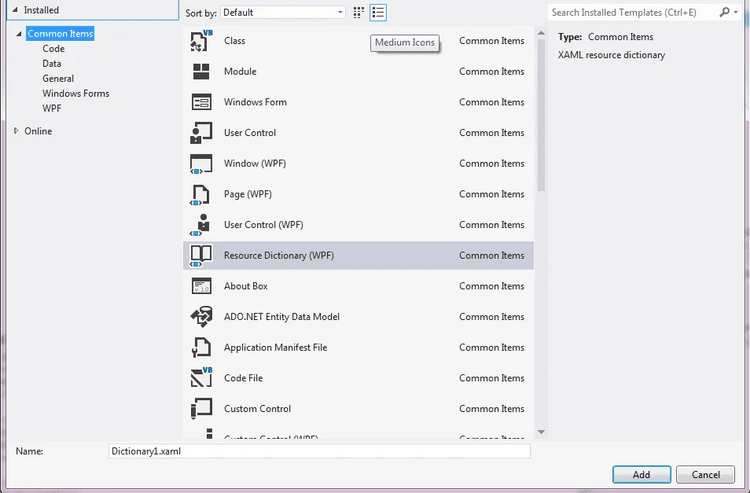

Рис. 14.3. Добавление файла ресурсов разработчика

3. В столове «Имя» введем «сообщение», а в столоце изначениен - «Сообщение на языке по умолчанию» (см. рис. 14.4)

œ стройки▾ 📑добавить ресурс▾ 📑редактировать файл▾|📑▾|

||Имя|Значение|Комментарий▾|
|---|---|---|---|
|->| сообщение один|Сообщение на языке по умолчанию||
|œ|---|---|---|

Рис. 14.4. Добавление строки в редакторе ресурсов

Страница 357

------------

4. В меню Файл выберем «Сохранить `ProjectResource.resx`» Можно сохранить файл, закрывая конструктор ресурсов.
5. Выполним действия 1-4 еще четыре раза, чтобы создать новые `resx`-файлы разработчика с именами `ProjectResource.de.resx`, `ProjectResource.de-AT.resx`, `ProjectResource.en-AU.resx` и `ProjectResource.fr-FR.resx` соответственно для языков: немецкого нейтрального, немецкого для Австрии, английского для Австралии и французского для Франции.

Сообщения добавим на соответствующем языке. Для всех языков имя ресурса должно быть одним и тем же (в нашем примере «сообщение1»), а значения — разными. Для английского языка введем «`The message in English for Australia`», а для немецких - «`Die Meldung in deutscher Sprache`» и «`Beitrag in deutscher Sprache für Österreich`». Для французского — «`Message en français pour la France`». В результате этих действий в проект будут добавлены перечисленные `resx`-файлы, а для `resx`-файла языка по умолчанию будет создан файл `ProjectResource.Designer.cs` с классом со строгой типизацией ресурса (см. рис. 14.5).

Страница 358

---------

# 6. Соберём решение



    Обозреватель решений ▾📌X
    (<-)(->)🛖(+⏰)▾🧻↺📑📄🔧(!=)
    Обозреватель решений - поиск (Ctrl+f) 🔎▾

- (C#) ResourceWinForm1
    - 🔧 Properties
    - 🧻 🧻 Ссылки
        - 📄🔧 App.config
    - 📄 Form1.cs
        - 📄 Form1.de-AT.resx
        - 📄 Form1.de.resx
        - 📄 Form1.Designer.cs
        - 📄 Form1.en-AU.resx
        - 📄 Form1.resx
        - 📄 Form1
    - (C#) Program.cs
        - 📄 ProjectResource.de-AT.resx
        - 📄 ProjectResource.de.resx
        - 📄 ProjectResource.en-AU.resx
        - 📄 ProjectResource.fr-FR.resx
    - 📄 ProjectResource.resx
        - 📄 ProjectResource.Designer.cs

Рис. 14.5. `Resx`-файлы разработчика и класс со строгой типизацией


Таким образом, в результате выполнения вышеперечисленных шагов для выбранных культур будут созданы `dll`-библиотеки (вспомогательные сборки) с локальными ресурсами формы и ресурсами разработчика. В частности, файл `ProjectResource.resx` будет преобразован в файл `ProjectResource.resources` и внедрен в основную сборку `ResourceWinForms1.еxе`. Файл `ProjectResource.de.resx` будет преобразован в файл `ProjectResource.de.resources` и внедрен во вспомогательную сборку `ResourceWinForms1.resources.dll`, находящуюся в папке `de`. Точно также и файлы `ProjectResource.de-AT.resx` и `ProjectResource.en-AU.resx` будут преобразованы соответственно в файлы `ProjectResource.de-AT.resources` и `ProjectResource.en-AU.resources` и внедрены во вспомогательные сборки соответствующих папок. Для французского ресурса будет создан файл `ProjectResource.fr-FR.resources`, новая папка `fr-FR` и вспомогательная сборка (см. рис. 14.6).

Страница 359

------

- Имя
- 📄 de
- 📄 de-AT
- 📄 en-AU
- 📄 fr-FR
- 🧻 ResourceWinForms1.exe
- 🧻 ResourceWinForms1.exe.config



Рис. 14.6. Структура каталога bin debug
 
Следует заметить, если локальный `res`-фаил формы для соответствующей культуры отсутствует, то будет создана вспомогательная сборка только для `resx`-файла разработчика (см. французский язык).
 
# Доступ к ресурсам разработчика
Для чтения текущего ресурса разработчика будем использовать класс со строгой типизацией.

1. В редакторе кода импортируем пространства имен:
```
using System.Resources;
using System. Globalization;
using System.Threading;
```

Страница 360

----------

2. Дважды нажмём кнопку, чтобы отобразить код для обработчика события `Сlick`, и добавим следующий код: `MessageBox.Show(ProjectResource.сообщение1);` где `ProjectResource` - это строго типизированный класс ресурсов разработчика, находящийся в файле `ProjectResource.Designer.cs`. `Cообщение1` - это имя сообщения, выбранного из ресурсов, и оформленного в виде свойства класса. Сообщение будет представлено на языке, который задан по умолчанию или определен свойством `CurrentUlCulture`. Если не хотите использовать строго типизированный класс, то можете использовать менеджер ресурсов в явном виде:
```
ResourceManager rm =
    new ResourceManager(
        "ResourceWinForms1.ProjectResource"
        ,typeof(Form1).Assembly
    )
;
MessageBox.Show(rm.GetString("сообщение1"));
```
3. Соберём решение и запустим программу. Щелкнем кнопку. В окне сообщения появится строка, соответствующая установленному языку и региональным параметрам интерфейса (в нашем случае русскому языку).
4. Сменим культуру пользовательского интерфейса, вставив перед вызовом метода `InitializeComponent();` оператор `Thread.CurrentThread.CurrentUICulture = new Cultureinfo ("en-AU");`
5. Выполним построение и запустим программу. Щелкнем кнопку. Вы увидите сообщение на английском языко для Австралии (см. рис. 14.7). Если свойство `CurrentUlCulture` не задано явно в коде приложения, то оно задается по умолчанию в начале работы приложения.

Страница 361

-----------

    Œ Form 1 _OX
    String resource
    Œ X
    The message in English for Australia
    Кнопка:OK



Рис. 14.7. Форма и окно сообщения на английском языкс для Австралии

Следует заметить, что при объединении файлов ресурсов в один `eхе`- или `dll`-файл, корневые имена файлов локальных ресурсов и разработчика - разные. В первом случае — это `ResourceWinForms1.Form1` а во втором - `RespurceWinForms1.ProjectResource` то есть имена файлов, объединяющих ресурсы, сохраняются в интерфейсе. Все `dll-файлы` ресурсов имеют одинаковые имена, формируемые следующим образом: `ИмяПриложения.resources.dll`, например `Мультиязычное.resources.dll`.

# Поиск ресурсов
Если ресурсы для заданной культуры не обнаруживаются, система пытается использовать ресурсы нейтральной культуры Например, если ресурсы для культуры `en-AU` не заданы, система осуществляет поиск ресурсов для языка `еп`. Сборка ресурсов нейтральной культуры называется родительской. Если ресурсы для языка `еп` также отсутствуют, используются ресурсы культуры по умалчанию (в нашем случас, русской).

Страница 362

-------

Не все свойства формы и элементов управления дублируются во вспомогательных сборках. Например, если координаты элементов управления для какой-либо культуры остались без изменения, то в соответствующей вспомогательной сборке эти координаты не сохраняются. Финансовые или временные ограничения могут не позволить создать набор ресурсов для каждого региона. В такой ситуации можно разработать единственную вспомогательную сборку для родительского (нейтрального) языка, которая будет использоваться для всех регионов, связанных с языком. Например, можно создать одну вспомогательную сборку для английского языка (`en`), которая будет вызываться пользователями при запросе англоязычных ресурсов для конкретного региона, и одну сборку на немецком (`de`) для пользователей, запрашивающих ресурсы немецкоязычной версии для определенного региона. В этом случае запросы ресурсов для немецкоязычной версии Германии (`de-DE`), немецкоязычной версии Австрии (`de-AT`) и немецкоязычной версии Швейцарии (`de-CH`) будут переданы во вспомогательную сборку для немецкого языка (`de`). Таким образом, если осуществляется разработка ресурсов для одного языка, но разных регионов, рекомендуется, по возможности, все одинаковые ресурсы локализовать в нейтральной сборке.

# Использование класса строго типизированного ресурса
Для более удобного доступа к ресурсам разработчика системой автоматически создается класс ресурсов со строгой типизацией. Класс содержится в файле `имяФайла.Designer.cs`, например `ProjectResource.Designer.cs` для ресурсов разработчика (см. рис. 14.5). Имя этого класса совпадает с именем `resx`-файла! В нашем случае это `ProjectResource`. Класс инкапсулирует набор свойств, имена которых совпадают с именами соответствующих ресурсов. Свойства являются статическими и доступны только для чтения. Они позволяют извлекать как связанные, так и внедренные ресурсы. Выше мы рассмотрели пример использования класса для получения строки с именем «сообщение 1».

__Пример.__ Извлечение ресурса `Clock` из `resx`-файла `Resource1.resx` и использование ресурса в качестве отображаемого рисунка элемента управления `PictureBox`.
```csharp
pictureBox1.Image = Resource1.Clock; // Ресурс разработчика
```
Для локальных `resx`-файлов, например `Form1.resx`, строго типизированные классы не создаются, так как разработчик не должен вмешиваться в работу сгенерированного системой кода.

Страница 363

-------

# ЛОКАЛИЗАЦИЯ ПРИЛОЖЕНИЯ
Локализация приложения заключается в настройке приложения по месту его использования, то есть в выборе пользователем требуемой культуры и настройке приложения на эту культуру. Существует несколько способов локализации.
# Смена языка с помощью меню
Ниже рассматривается способ представления пункта меню в виде списка `ComboBox`, содержащего доступные приложению культуры. Особенность способа заключается в том, что список формируется динамически на основе имен каталогов текущей папки, содержащих вспомогательные сборки с ресурсами культуры. Текущая культура запоминается в подразделе `Language` подраздела текущего пользователя `CurrentUser` системного реестра. Меню представляется либо на языке по умолчанию (русском), либо на английском в зависимости от того, запомнен ли русский язык в реестре или нет. Представление списка меню на языках других доступных культур выполняется аналогично, но из-за большого объема работы здесь не рассматривается. Главное окно программы и раскрытый список культур представлен на рис. 14.8. Список имеет имя `Languages`. Из рисунка следует, что каждая строка списка меню содержит полное наименование культуры и код этой культуры. Если каталог какой-либо вспомогательной сборки будет удален или добавлен новый, то список также изменится. При этом перекомпилировать программу не нужно.

Страница 364

---------

    Œ Form1 _OX
     Available languages ▾
    Кнопка: Строка-ресурс

    吧 Formt _OX
    Avallable language:▾
- Русский (Россия) : ru-RU
- Немецкий (Германия): de-DE
- Немецкий (Австрия) : de-AT
- Английский (США) : en-US
- Английский (Австралия) : en-AU
- Французский (Франция) : fr-FR

Рис. 14.8. Главное окно программы (слева) и его раскрытое меню (справа)

Ниже приведен листинг программы, реализующей рассматриваемый способ.
```csharp
using System;
using System.Windows.Forms;
using System.Globalization;
using System.Threading;
using System.Resources;
using Microsoft.Win32;
using System.IO;
using System.Collections.Generic;
```

Cтраница 365

-----------------

```csharp
public partial class Form1 : Form
{
    RegistryKey cUser;
    RegistryKey subKey;
    string cultureCat;
    CultureInfo cultureDefault;
    List<string> items = new List<string>;
    public Form1()
    {
        cultureDefault = Thread CurrentThread. CurrentUlCulture;
        // Чтение культуры из реестра и установка ее в качестве текущей.
        cUser = Registry.CurrentUser;
        subKey = cUser.OpenSubKey("Language");
        if (subKey != null)
        {
            cultureCur = (string)subKey.GetValue("culture");
            Thread.CurrentThread.CurrentUICulture = new subKey.Close();
            CultureInfo(cultureCur);
            // Текущая культура программы.
            cultureCur = Thread.CurrentThread.CurrentUICulture.Name;
            InitializeComponent();
            // Заполним список меню именами доступных культур.
            CreateList();
            Languages.Items.AddRange(items.ToArray());
        }
```
Страница 366

------------

```csharp        
        //---- Заполним именами доступных культур массив items.
        private void CreateList ()   
        {
            string cit;
            // Добавим культуру по умолчанию (она в основной сборке).
            clt = cultureDefault.DisplayName;
            cit += " :" + cultureDefault.Name;
            items.Add(clt):
            // Добавим культуры по именам каталогов вспомогательных сборок.
            string[] dis = Directory. GetDirectories".");
            foreach (var dir in dis)
            {
                try
                {
                    string d = Path.GetFileName(dir);
                    clt = CultureInfo.CreateSpecificCulture(d).DisplayName;
                    clt += " : " + "?;?";
                }
                catch
                { continue; }
                Culturelnfo.CreateSpecificCulture(d).Name;
                items.Add(clt);
            }
            // Пропускаем папки, не относящиеся к культурным ресурсам.
        }
```

Страница 367

----------

```csharp
        //---- Кнопка
        private void button1_Click(object sender, EventArgs e)
        { MessageBox.Show(ResourceWinForms1.ProjectResource.сообщение1); }
        // Выборка языка из списка и установка нового языка.
        private void Languages_TextChanged(object sender,
        {
            string citCur = Thread.CurrentThread.CurrentUlCulture.Name;
            string[] sep = {" : " };
            string[] names = Languages. Text. Split(sep, StringSplitOptions.RemoveEmptyEntries);
            if (names.Length == 2 && names[1] != cltCur)
            {
                this.Controls.Clear);
                // Установить UI новой культуры.
                Thread.CurrentThread.CurrentUICulture = new Cultureinfo(names[1]);
                Thread.CurrentThread.CurrentCulture = new Culturelnfo(names[1]);
                InitializeComponent();
                // Создать список.
                Languages.Items.AddRange(items.ToArray());
            }
        }
```
Страница 368

---------------

```csharp
        // Если был установлен новый язык, то запоминаем его в реестре.
        private void Form1_FormClosed (object sender, FormClosedEventArgs e)
        {
            string cultureNew = Thread.CurrentThread.CurrentUlCulture.Name;
            if (cultureCur l= cultureNew)
            {
                subkey = cUser.CreateSubKey ("Language");
                // Создать данные для подраздела "Параметры теста"
                subKey.SetValue("culture", cultureNew);
                subKey.Close(); 
            }
        }
    }
}
```
Поскольку инициализация формы и ее элементов управления осуществляется в конструкторе Form1, который выполняется один раз, то при смене языка необходимо контейнер формы очистить и после установки нового языка выполнить инициализацию еще раз. __Для работы__ с системным реестром в программу необходимо добавить пространство имен `Microsoft.Win32` . Конструктор формы изменен для считывания культуры из реестра. Для запоминания новой культуры в реестре добавлен обработчик события `FormClosed`. Если при завершении программы фиксируется смена языка, то обработчик события `FormClosed` создает дочерний узел `Language` и запоминает в нем новую культуру под именем `culture`. При следующем запуске программы значение культуры будет считано из подраздела и установлено в качестве текущей.

__В приведенном примере__ для создания объекта для работы с подразделами ключа `CurrentUser` используется оператор

    RegistryKey User; cUser = Registry.CurrentUser;

Метод `OpenSubKey` этого объекта открывает в реестре подраздел, метод `CreateSubKey` создает подраздел, метод `SetValue` записывает в подраздел значение заданного ключа, а метод `GetValue` читает значение для заданного ключа из подраздела. __Если потребуется удалить подраздел__, то можно воспользоваться таким фрагментом кода:

```csharp
Registry cUser = Registry.CurrentUser;
subKey = cUser.OpenSubKey ("Language", true);
subKey.DeleteSubKey("");
subKey.Close();
```
Страница 369

----------

Текущий каталог приложения представлен на рис. 14.9. Из рисунка следует, что приложение, кромс культуры по умолчанию, использует культуры: `de`, `de-AT`, `en`, `en-AU` и `fr-FR`.



- 🧻 de
- 🧻 de-AT
- 🧻 en
- 🧻 en-AU
- 🧻 fr-FR



- 🧻 Не подходящая папка
- 🧻 ResourceWinForms1.exe
- 🧻 ResourceWinForms1.exe.config
- 🧻 ResourceWinForms1.pdb
- 🧻 ResourceWinForms1.vshost.exe
- 🧻 ResourceWinForms1.vshost.exe.config
- 🧻 ResourceWinForms1.vshost.exe.manifest

Рис. 14.9. Состав текущего каталога

Для создания списка каталогов текущей папки и выделения имени каталога из пути используются классы `Directory` и `Path` пространства имен `System.IO`. Поскольку в текущей папке могут оказаться каталоги, не относящиеся к какой-либо культуре (на рис. 14.9 — «Неподходящая папка»), то обработка таких каталогов порождает исключение. Обработка исключения сводится к переходу к следующему каталогу списка. Строка для культуры по умолчанию не связана с каталогом, поэтому она добавляется в список меню отдельно.

Страница 370

------------